In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from astropy.table import Table
from matplotlib import pyplot as plt
import healpy as hp
import fitsio
from glob import glob
from time import time
from scipy.interpolate import splrep, splev

In [3]:
import sys 

sys.path.append(os.path.join(os.getenv("HOME"),'perlmutter_legacysim_runs'))
import useful_functions as ut

sys.path.append(os.path.join(os.getenv("HOME"),'LSS','py'))
from LSS.imaging import sysnet_tools
import LSS.common_tools as common

In [ ]:
#sys.path.append("/global/homes/a/arosado/sysnetdev")
from sysnet.sources.train import forward
from sysnet.sources.models import DNNPoisson
from sysnet.sources.io import load_checkpoint, ImagingData, MyDataSet, DataLoader

In [4]:
def extrapolate_weights(datapix, wt_map, k=1, der=0):
    # get missing weight, note: pixels must be sorted
    pix = datapix
    hpmap = wt_map
    is_unseen = hpmap[pix] == hp.UNSEEN
    t0 = time()
    # #https://datasciencestunt.com/extrapolation-vs-interpolation/#Spline_Extrapolation_with_Python_Code
    x = pix[~is_unseen] 
    y = hpmap[x]#[pix][~is_unseen]
    #print(x,y)
    # Spline extrapolation function
    spl = splrep(x, y, k=k)
    x_new = pix[is_unseen]
    #print(is_unseen,x_new)
    y_new = splev(x_new, spl, der=der)
    print(f"Spline extrapolation finished at {time() - t0:.3f} s")
    
    return x_new, y_new

def sn_cont_wts(data, sn, normalize=False, plot_weights=False):
    dpixs = sysnet_tools.radec2hpix(nside,data['RA'],data['DEC'])
    is_unseen = sn[dpixs] == hp.UNSEEN
    print('unseen values: ', is_unseen.sum())
    if is_unseen.sum() != 0:
        # extrapolate any missing weights
        pix = np.unique(dpixs)
        pixi,wts = extrapolate_weights(np.sort(pix), sn, k=1, der=0)
        print(sn[pixi],sn[pixi].size)
        sn[pixi] = wts
        print(sn[pixi],sn[pixi].size)
        if plot_weights:
            plt.scatter(pix,sn[pix])
            plt.scatter(pixi,sn[pixi],c='r')
            plt.show()
    #print(dpixs,sn[dpixs])
    print(np.mean(sn[dpixs]),np.median(sn[dpixs]))
    if normalize: wts = sn[dpixs]/np.median(sn[dpixs])
    else: wts = sn[dpixs]
    print('sn_wts min/max: ',wts.min(),',',wts.max())
    return wts

In [5]:
regions = ['N','S']
#zl = ['0.8_1.1','1.1_1.6']
tp = 'LRG' # tracer type ['ELG_LPOnotqso','LRG','QSO]
sv = 'v0.6'          # survey version
nside = 256
nran = 4
nest=True
#zmin,zmax = [1.1,1.6]
#zrl = [(0.8,1.1),(1.1,1.6)]
if tp[:3] == 'ELG':
    zrl = [(0.8,1.1),(1.1,1.6)]
if tp[:3] == 'QSO':
    zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
if tp[:3] == 'LRG':
    zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
if tp[:3] == 'BGS':
    zrl = [(0.1,0.4)] 

survey_dir = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{sv}/"
outdir  = os.path.join(os.getenv('HOME'),'sysgen2')
sysdir  = os.path.join(survey_dir,'sysnet')
prepdir = sysdir

mockdir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/'
mockid = 10
prep_mockdir = outdir+f"/mock{mockid}"
if not os.path.isdir(prep_mockdir):
    os.makedirs(prep_mockdir)
    print(f"created dir: {prep_mockdir}")

# Forward model 
To do:
- instead of using features from prepared data used to train, try making templates based on mock hpix. I think this way all mock hpix will have assigned weights, and I would not need to extrapolate them later on. After doing this, we now get weights for the majority of pixels, only 1-2 are left out.


In [8]:
def do_forward(checkpoints,templates,outfn,axes=[1, 2, 3, 4, 5, 6, 7, 8]):
    nnw_list = [] 
    #hpix_list = []
    num_features = len(axes) # nside=1024, 27 for nside=256
    nnstruct = (4, 20)
    
    ti = time()
    model = DNNPoisson(*nnstruct, input_dim=num_features)
    for i, chck in enumerate(checkpoints):        

        t0 = time()
        checkpoint = load_checkpoint(chck, model)
        img_data = ImagingData(templates, checkpoint['stats'], axes=axes)
        dataloader = DataLoader(MyDataSet(img_data.x, img_data.y, img_data.p, img_data.w),
                                 batch_size=2000000,
                                 shuffle=False) # num_workers=4
                                
        #print(f'finish data in {time()-t0:.2f} s, {i}')
        result = forward(model, dataloader, {'device':'cpu'})        
        nnw = result[1].numpy().flatten()
        hpix = result[0].numpy()
        nnw_list.append(nnw)
        #hpix_list.append(hpix)
        #print(f'finished forward pass in {time()-t0:.2f} s, {i}')
        
    print(f'finished forward pass for {len(checkpoints)} checkpoints in {time()-ti:.2f} s')   
    nnw_mean = np.mean(nnw_list,axis=0)    
    #print(nnw_mean)
    dt = Table([hpix, nnw_mean], names=['hpix', 'weight'])
    dt.write(outfn, format='fits')
    print(f'save in {outfn}')

In [10]:
%%time
# load data
datl = []
datn = []
dats = []
for reg in ['NGC','SGC']:
    if tp=='ELG_LOPnotqso':
        tp_="ELG_LOP"
        dfn = os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_clustering.dat.fits")
    else:
        dfn = os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_clustering.dat.fits")  
    print(dfn)
    dat = fitsio.read(dfn)
    #zgood = (dat['Z'] > zmin) & (dat['Z'] < zmax)
    #dat = dat[zgood]
    if reg == 'NGC':
        is_north = dat['DEC'] >= 32.375
        datn.append(dat[is_north])
        dats.append(dat[~is_north])
    else:
        dats.append(dat)
    datl.append(dat)
dat = np.concatenate(datl)
datn = np.concatenate(datn)
dats = np.concatenate(dats)

# load randoms
ranl = []
rands_n = []
rands_s = []
for reg in ['NGC','SGC']:
    if tp=='ELG_LOPnotqso':
        tp_="ELG_LOP"
        rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
    else:
        rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
    #print(rfn_l)
    for rfn in rfn_l:
        ran = fitsio.read(rfn, columns=['RA', 'DEC']) 
        if reg == 'NGC':
            is_north = ran['DEC'] >= 32.375
            rands_n.append(ran[is_north])
            rands_s.append(ran[~is_north])
        else:
            rands_s.append(ran)
        ranl.append(ran)
drands = np.concatenate(ranl)
rands_n = np.concatenate(rands_n)
rands_s = np.concatenate(rands_s)

/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock10/ELG_LOP_complete_gtlimaging_NGC_clustering.dat.fits
/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock10/ELG_LOP_complete_gtlimaging_SGC_clustering.dat.fits
CPU times: user 11.1 s, sys: 8.61 s, total: 19.8 s
Wall time: 24.5 s


In [11]:
if tp[:3] == 'ELG':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','EBV_DIFF_GR','EBV_DIFF_RZ','HI']

if tp[:3] == 'BGS':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','HI']

if tp[:3] == 'LRG':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','HI','PSFDEPTH_W1']
    #fit_maps.append('PSFDEPTH_W1')
#    fit_maps = ['STARDENS','HI','BETA_ML','GALDEPTH_G', 'GALDEPTH_R','GALDEPTH_Z','PSFDEPTH_W1','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z']

if tp[:3] == 'QSO':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z','EBV_DIFF_GR','EBV_DIFF_RZ','HI']
    fit_maps.append('PSFDEPTH_W1')
    fit_maps.append('PSFDEPTH_W2')
    
print(len(fit_maps),fit_maps)

10 ['STARDENS', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'EBV_DIFF_GR', 'EBV_DIFF_RZ', 'HI']


In [12]:
%%time
"""
# maps used when fitting for weights
bands = ["G","R","Z"]
if tp[:3] == 'ELG':
    fit_maps = ['STARDENS'] + \
               [f'PSFSIZE_{b}' for b in bands] + \
               [f'GALDEPTH_{b}' for b in bands] + \
               ['EBV_DIFF_GR','EBV_DIFF_RZ','HI']
print(len(fit_maps),fit_maps)
"""

# load Ronpu EBV maps
dirmap = '/global/cfs/cdirs/desicollab/users/rongpu/data/ebv/v0/kp3_maps/'
eclrs = ['gr','rz']
debv = Table()
for ec in eclrs:
    ebvn = fitsio.read(dirmap+'v0_desi_ebv_'+ec+'_'+str(nside)+'.fits')
    debv_a = ebvn['EBV_DESI_'+ec.upper()]-ebvn['EBV_SFD']
    debv_a = hp.reorder(debv_a,r2n=True)
    debv['EBV_DIFF_'+ec.upper()] = debv_a
    
prep_tables = []
for zl in zrl:
    zw = str(zl[0])+'_'+str(zl[1])
    zmin,zmax = zl[0],zl[1]
    for reg in ['N','S']:
        if tp[:3] == 'ELG':
            pwf = os.path.join(survey_dir,'hpmaps',"QSO"+'_mapprops_healpix_nested_nside'+str(nside)+'_'+reg+'.fits')
        else:
            pwf = os.path.join(survey_dir,'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'_'+reg+'.fits')
        sys_tab = Table.read(pwf)
        cols = list(sys_tab.dtype.names)
        for col in cols:
            if 'DEPTH' in col:
                bnd = col.split('_')[-1]
                sys_tab[col] *= 10**(-0.4*common.ext_coeff[bnd]*sys_tab['EBV'])
        for ec in ['GR','RZ']:
            if 'EBV_DIFF_'+ec in fit_maps: 
                sys_tab['EBV_DIFF_'+ec] = debv['EBV_DIFF_'+ec]
        
        if reg == 'N':
            d,r = datn,rands_n
        else:
            d,r = dats, rands_s
        zgood = (d['Z'] > zmin) & (d['Z'] < zmax)
        
        data_hpmap, rands_hpmap = sysnet_tools.hpixelize(nside, d[zgood], r, nest=False, return_mask=False, nest2ring=False) 
        hpmaps = sysnet_tools.create_sysmaps(sys_tab, nest=nest, columns=fit_maps)
        prep_table = sysnet_tools.hpdataset(data_hpmap, rands_hpmap, hpmaps, fit_maps)
        prep_tables.append(prep_table)
        fnout = os.path.join(prep_mockdir,'prep_'+tp+zw+'_'+reg+'.fits')
        print(fnout)
        fitsio.write(fnout,prep_table)


nran_exp: 1370.7813029491933
/global/homes/a/arosado/sysgen2/mock10/prep_ELG_LOPnotqso0.8_1.1_N.fits
nran_exp: 1520.476588650975
/global/homes/a/arosado/sysgen2/mock10/prep_ELG_LOPnotqso0.8_1.1_S.fits
nran_exp: 1370.7813029491933
/global/homes/a/arosado/sysgen2/mock10/prep_ELG_LOPnotqso1.1_1.6_N.fits
nran_exp: 1520.476588650975
/global/homes/a/arosado/sysgen2/mock10/prep_ELG_LOPnotqso1.1_1.6_S.fits
CPU times: user 20.4 s, sys: 5.13 s, total: 25.6 s
Wall time: 26 s


In [13]:
%%time
for zl in zrl:
    zw = str(zl[0])+'_'+str(zl[1])
    print(zw)
    for reg in regions:
        print(reg)
        outfn = os.path.join(prep_mockdir,f"nn-weights_{tp}{zw}_{reg}.fits")
        nndir   = os.path.join(sysdir,f"{tp}{zw}_{reg}/")
        chcks   = glob(nndir+'model_*/best.pth.tar')
        templates = fitsio.read(prep_mockdir+f"/prep_{tp}{zw}_{reg}.fits")
        axes = [i for i in range(templates['features'].shape[1])]
        print(len(axes))
        
        """
        m = templates
        mp = sysnet_tools.make_hp(m['label'],m['hpix'],nside,fill_with=hp.UNSEEN)
        hp.mollview(mp,rot=260)
        plt.show()
        """
        # we want the imaging weights due to EBV_DIFF only, which correspond to axes=8 in 'features'
        #for ax in range(templates['features'].shape[1]):
        #    if ax!=8:
        #        templates['features'][:,ax] = np.full(templates['features'][:,ax].shape, np.median(templates['features'][:,ax]))

        #print(len(chcks), templates.size, chcks[:2])
        do_forward(chcks, templates, outfn, axes=axes)
        
#print(chcks)

0.8_1.1
N
10
finished forward pass for 25 checkpoints in 16.85 s
save in /global/homes/a/arosado/sysgen2/mock10/nn-weights_ELG_LOPnotqso0.8_1.1_N.fits
S
10
finished forward pass for 25 checkpoints in 52.17 s
save in /global/homes/a/arosado/sysgen2/mock10/nn-weights_ELG_LOPnotqso0.8_1.1_S.fits
1.1_1.6
N
10
finished forward pass for 25 checkpoints in 14.89 s
save in /global/homes/a/arosado/sysgen2/mock10/nn-weights_ELG_LOPnotqso1.1_1.6_N.fits
S
10
finished forward pass for 25 checkpoints in 51.52 s
save in /global/homes/a/arosado/sysgen2/mock10/nn-weights_ELG_LOPnotqso1.1_1.6_S.fits
CPU times: user 2min 14s, sys: 1.39 s, total: 2min 15s
Wall time: 2min 17s


In [14]:
for zl in zrl:
    zw = str(zl[0])+'_'+str(zl[1])
    count_i = np.zeros(12*nside*nside)
    wind_i = np.zeros(12*nside*nside)
    for reg in ['N','S']:
        print(reg)
        outfn = os.path.join(prep_mockdir,f"nn-weights_{tp}{zw}_{reg}.fits")
        nn = fitsio.read(outfn)
        wind_i[nn['hpix']] += nn['weight'] 
        count_i[nn['hpix']] += 1.0
        
    output_path = os.path.join(prep_mockdir,f"nn-weights_{tp}{zw}_NS.fits")
    #print(output_path)
    is_good = count_i > 0.0
    wind_i[is_good] = wind_i[is_good] / count_i[is_good]
    wind_i[~is_good] = hp.UNSEEN
    hp.write_map(output_path, wind_i, dtype=np.float64, fits_IDL=False) 
    print(f"saved {output_path}")

N
S
saved /global/homes/a/arosado/sysgen2/mock10/nn-weights_ELG_LOPnotqso0.8_1.1_NS.fits
N
S
saved /global/homes/a/arosado/sysgen2/mock10/nn-weights_ELG_LOPnotqso1.1_1.6_NS.fits


# Contaminate Mock

/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock10/LRG_complete_gtlimaging_NGC_clustering.dat.fits
	 0.4 0.6
unseen values:  0
3.8792108495835955 4.0050482749938965
sn_wts min/max:  0.5641712687942119 , 1.349105717869391
	 0.6 0.8
unseen values:  1
Spline extrapolation finished at 0.008 s
[-1.6375e+30] 1
[6.15437778] 1


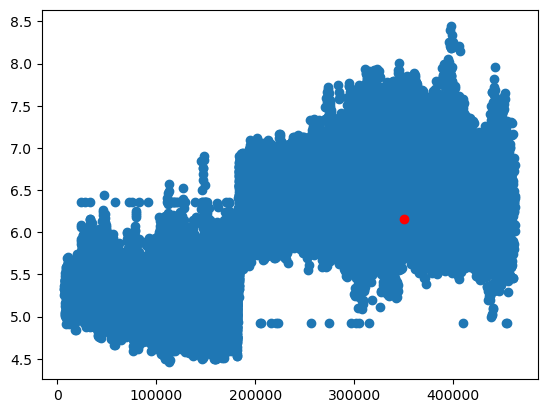

6.058094935475501 6.210284471511841
sn_wts min/max:  0.7176882089292613 , 1.3588781956079934
	 0.8 1.1
unseen values:  2
Spline extrapolation finished at 0.008 s
[-1.6375e+30 -1.6375e+30] 2
[5.62547073 7.17206192] 2


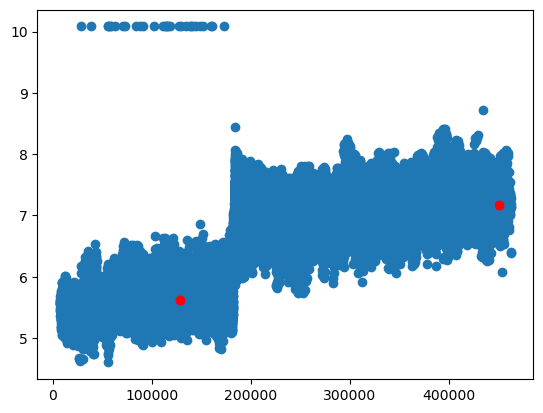

6.702527143324466 7.019391059875488
sn_wts min/max:  0.6553749712140634 , 1.4364325682218204
/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock10/LRG_complete_gtlimaging_SGC_clustering.dat.fits
	 0.4 0.6
unseen values:  0
4.193258387105548 4.181037425994873
sn_wts min/max:  0.8007607201009184 , 1.2953698625418855
	 0.6 0.8
unseen values:  1
Spline extrapolation finished at 0.005 s
[-1.6375e+30] 1
[5.90563989] 1


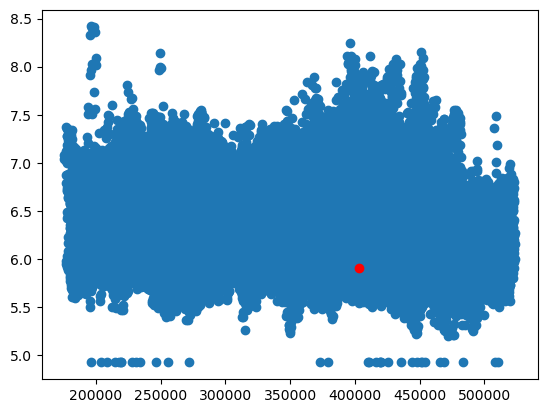

6.352850268872426 6.337059020996094
sn_wts min/max:  0.7770167834281029 , 1.328353465099788
	 0.8 1.1
unseen values:  0
7.00014221399032 6.998960971832275
sn_wts min/max:  0.7451935343545749 , 1.2546366182866264
CPU times: user 3.96 s, sys: 1.1 s, total: 5.06 s
Wall time: 5.92 s


In [6]:
%%time
# load data
datl = []
datn = []
dats = []
for reg in ['NGC','SGC']:
    if tp=='ELG_LOPnotqso':
        tp_="ELG_LOP"
        dfn = os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_clustering.dat.fits")
    else:
        dfn = os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_clustering.dat.fits")  
    print(dfn)
    dat = Table.read(dfn)
    dat['WEIGHT_SNCONT'] = np.ones(len(dat))
    for zl in zrl:
        zw = str(zl[0])+'_'+str(zl[1])
        zmin,zmax = zl[0],zl[1]
        print('\t',zmin,zmax)
        zgood = (zmin < dat['Z']) & (dat['Z'] < zmax)
        sn_fn = os.path.join(prep_mockdir,f"nn-weights_{tp}{zw}_NS.fits")
        sn_wts = hp.read_map(sn_fn) 
        dat['WEIGHT_SNCONT'][zgood] = sn_cont_wts(dat[zgood],sn_wts,normalize=True,plot_weights=True)
    
    #zgood = (dat['Z'] > zmin) & (dat['Z'] < zmax)
    #dat = dat[zgood]
    if reg == 'NGC':
        is_north = dat['DEC'] >= 32.375
        datn.append(dat[is_north])
        dats.append(dat[~is_north])
    else:
        dats.append(dat)
    datl.append(dat)
dat = np.concatenate(datl)
datn = np.concatenate(datn)
dats = np.concatenate(dats)

In [ ]:
fitsio.write()

In [12]:
%%time
# load randoms
ranl = []
rands_n = []
rands_s = []
for reg in ['NGC','SGC']:
    if tp=='ELG_LOPnotqso':
        tp_="ELG_LOP"
        rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
    else:
        rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
    #print(rfn_l)
    for rfn in rfn_l:
        ran = fitsio.read(rfn, columns=['RA', 'DEC']) 
        if reg == 'NGC':
            is_north = ran['DEC'] >= 32.375
            rands_n.append(ran[is_north])
            rands_s.append(ran[~is_north])
        else:
            rands_s.append(ran)
        ranl.append(ran)
drands = np.concatenate(ranl)
rands_n = np.concatenate(rands_n)
rands_s = np.concatenate(rands_s)

CPU times: user 2.74 s, sys: 2.46 s, total: 5.19 s
Wall time: 5.78 s


In [8]:
if tp[:3] == 'ELG':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','EBV_DIFF_GR','EBV_DIFF_RZ','HI']

if tp[:3] == 'BGS':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','HI']

if tp[:3] == 'LRG':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','HI','PSFDEPTH_W1']
    #fit_maps.append('PSFDEPTH_W1')
#    fit_maps = ['STARDENS','HI','BETA_ML','GALDEPTH_G', 'GALDEPTH_R','GALDEPTH_Z','PSFDEPTH_W1','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z']

if tp[:3] == 'QSO':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z','EBV_DIFF_GR','EBV_DIFF_RZ','HI']
    fit_maps.append('PSFDEPTH_W1')
    fit_maps.append('PSFDEPTH_W2')
    
print(len(fit_maps),fit_maps)

9 ['STARDENS', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'HI', 'PSFDEPTH_W1']


In [9]:
%%time
# load Ronpu EBV maps
dirmap = '/global/cfs/cdirs/desicollab/users/rongpu/data/ebv/v0/kp3_maps/'
eclrs = ['gr','rz']
debv = Table()
for ec in eclrs:
    ebvn = fitsio.read(dirmap+'v0_desi_ebv_'+ec+'_'+str(nside)+'.fits')
    debv_a = ebvn['EBV_DESI_'+ec.upper()]-ebvn['EBV_SFD']
    debv_a = hp.reorder(debv_a,r2n=True)
    debv['EBV_DIFF_'+ec.upper()] = debv_a
    
dat_maps = []
cont_maps = []
rands_maps = []
hpmapsl = []
maskl = []
for zl in zrl:
    zw = str(zl[0])+'_'+str(zl[1])
    zmin,zmax = zl[0],zl[1]
    print('\t',zmin,zmax)
    for reg in ['N','S']:
        pwf = os.path.join(survey_dir,'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'_'+reg+'.fits')
        sys_tab = Table.read(pwf)
        cols = list(sys_tab.dtype.names)
        for col in cols:
            if 'DEPTH' in col:
                bnd = col.split('_')[-1]
                sys_tab[col] *= 10**(-0.4*common.ext_coeff[bnd]*sys_tab['EBV'])
        for ec in ['GR','RZ']:
            if 'EBV_DIFF_'+ec in fit_maps: 
                sys_tab['EBV_DIFF_'+ec] = debv['EBV_DIFF_'+ec]
        
        if reg == 'N':
            d,r = datn,rands_n
        else:
            d,r = dats, rands_s
        zgood = (d['Z'] > zmin) & (d['Z'] < zmax)
        
        data_hpmap, rands_hpmap = sysnet_tools.hpixelize(nside, d[zgood], r)
        cont_hpmap = sysnet_tools.hpixsum(nside,d[zgood]['RA'],d[zgood]['DEC'],weights=d[zgood]['WEIGHT_SNCONT'])
        hpmaps = sysnet_tools.create_sysmaps(sys_tab, nest=nest, columns=fit_maps)
        dat_maps.append(data_hpmap)
        cont_maps.append(cont_hpmap)
        rands_maps.append(rands_hpmap)
        hpmapsl.append(hpmaps)
        maskl.append(rands_hpmap>0)
        

	 0.4 0.6
	 0.6 0.8
	 0.8 1.1
CPU times: user 10.3 s, sys: 2.47 s, total: 12.8 s
Wall time: 13.2 s


In [ ]:
%%time 
# load full data catalog
zcolumn = 'Z_not4clus'
keep = ["RA","DEC","TARGETID","PHOTSYS","FRACZ_TILELOCID","WEIGHT_ZFAIL",
        "ZWARN","o2c","FRAC_TLOBS_TILES",zcolumn]#"WEIGHT_SYS"]
dfn = os.path.join(survey_dir,f"{tp}_full.dat.fits")
print(dfn)
dat_full = fitsio.read(dfn)#,columns=keep)

# load full randoms
rfn_l = [os.path.join(survey_dir,f"{tp}_{i}_full.ran.fits") for i in range(0,nran)]
#print(rfn_l)
ranl = []
for rfn in rfn_l:
    ran = fitsio.read(rfn, columns=['RA', 'DEC','PHOTSYS']) 
    ranl.append(ran)
rands = np.concatenate(ranl)

#selection
#sel_obs = dat_full['ZWARN'] != 999999
#sel_obs &= dat_full['o2c'] > 0.9
#sel_obs &= (zmin < dat_full[zcolumn]) & (dat_full[zcolumn] < zmax)

dat_full_list   = []
dat_fullc_list  = []
rands_full_list = []
mask_full_list = []
for zl in zrl:
    zw = str(zl[0])+'_'+str(zl[1])
    zmin,zmax = zl[0],zl[1]
    print(zw)
    for reg in ['N','S']:
        sn_fn = os.path.join(survey_dir,"sysnet",f"{tp}{zw}_{reg}","nn-weights.fits")
        sn_weights = fitsio.read(sn_fn)
        pred_counts = np.mean(sn_weights['weight'],axis=1)
        pix_weight = np.mean(pred_counts)/pred_counts
        pix_weight = np.clip(pix_weight,0.5,2.)
        sn_pix = sn_weights['hpix']
        snmap = np.ones(12*256*256)
        for pix,wt in zip(sn_pix,pix_weight):
            snmap[pix] = wt
        seld = dat_full['PHOTSYS'] ==  reg
        selr = rands['PHOTSYS'] == reg
        d = dat_full[seld]
        d = sysnet_tools.do_zcut(d,zmin,zmax,zcolumn,tp=tp[:3])
        r = rands[selr]
        dpix = sysnet_tools.radec2hpix(nside,d['RA'],d['DEC'])

        dwts = 1./d['FRAC_TLOBS_TILES'] * 1./d['FRACZ_TILELOCID'] * d['WEIGHT_ZFAIL']
        dat_full_list.append(sysnet_tools.hpixsum(nside, d['RA'],d['DEC'],weights=dwts))
        rmap = sysnet_tools.hpixsum(nside, r['RA'],r['DEC'])
        rands_full_list.append(rmap)
        mask_full_list.append(rmap>0)
        dat_fullc_list.append(sysnet_tools.hpixsum(nside, d['RA'],d['DEC'],weights=dwts*snmap[dpix]))


0.8_1.3
0


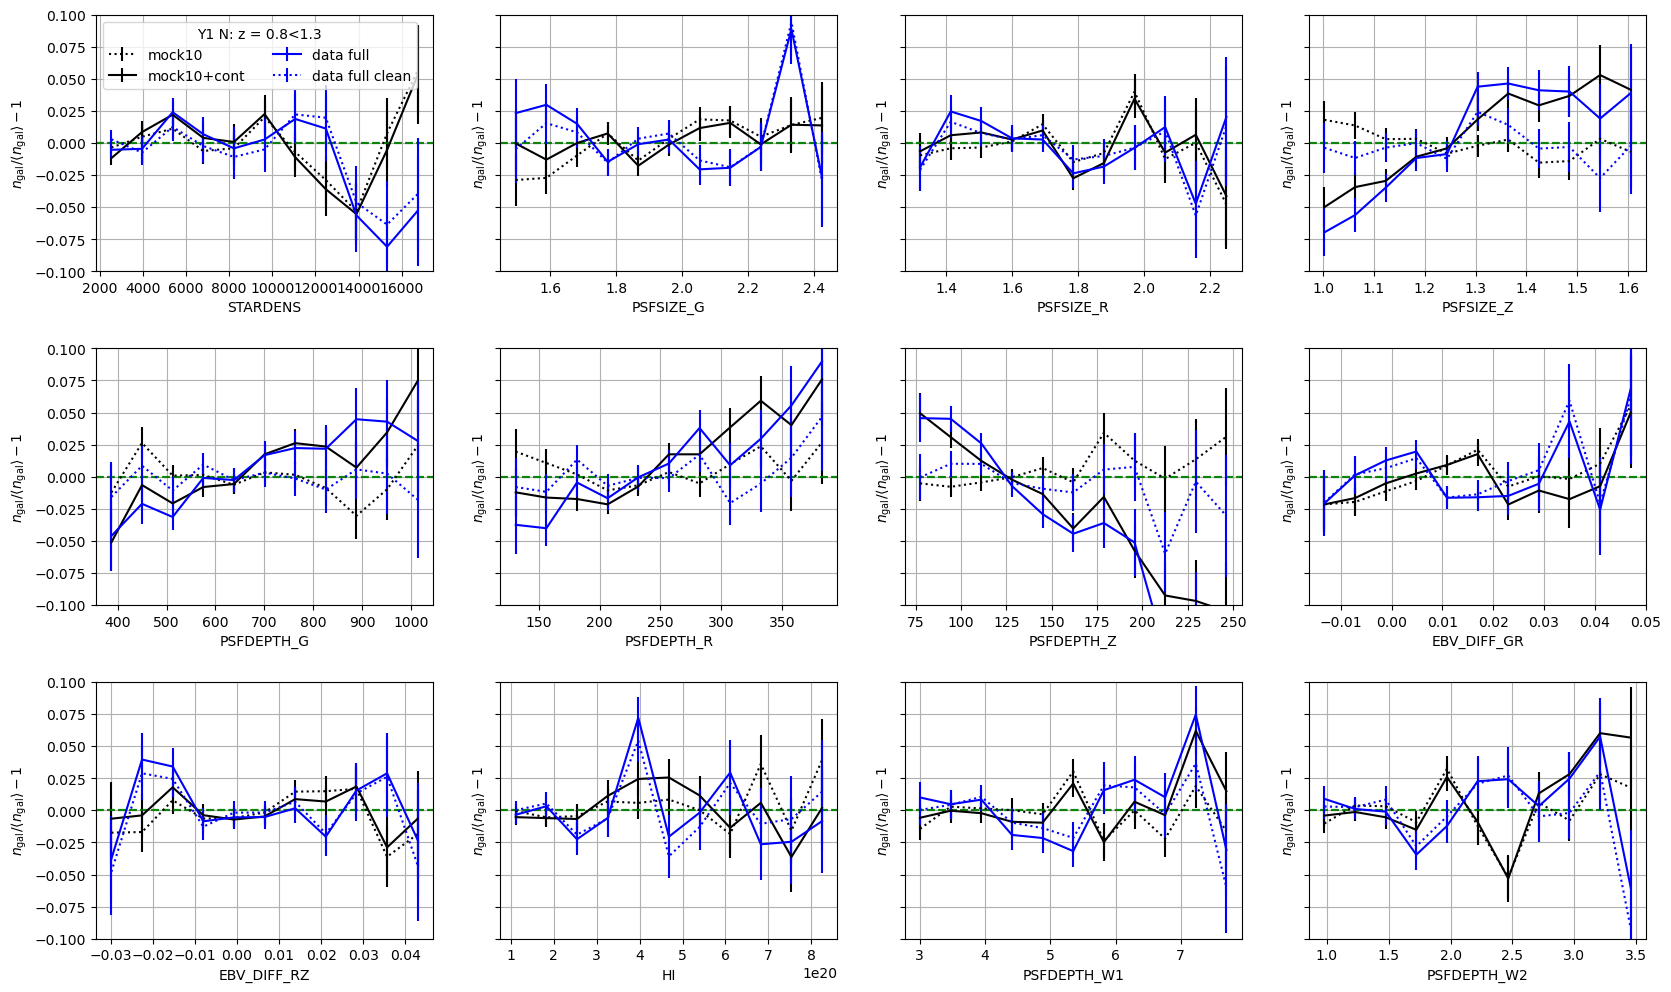

1


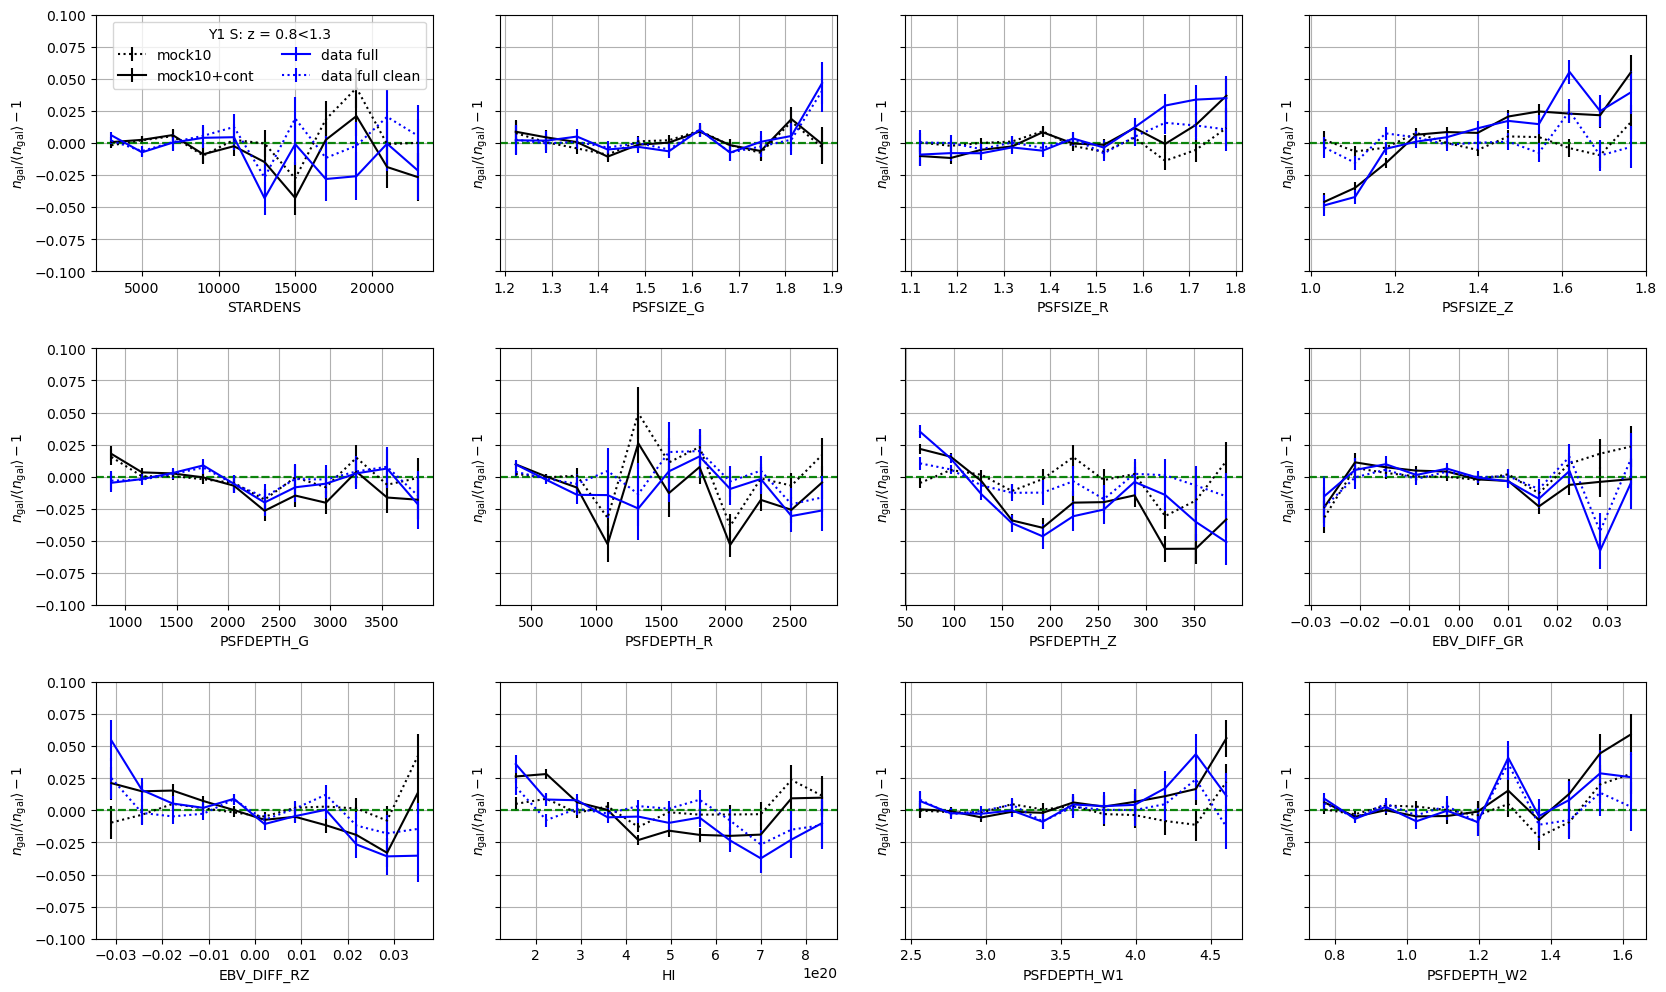

1.3_2.1
2


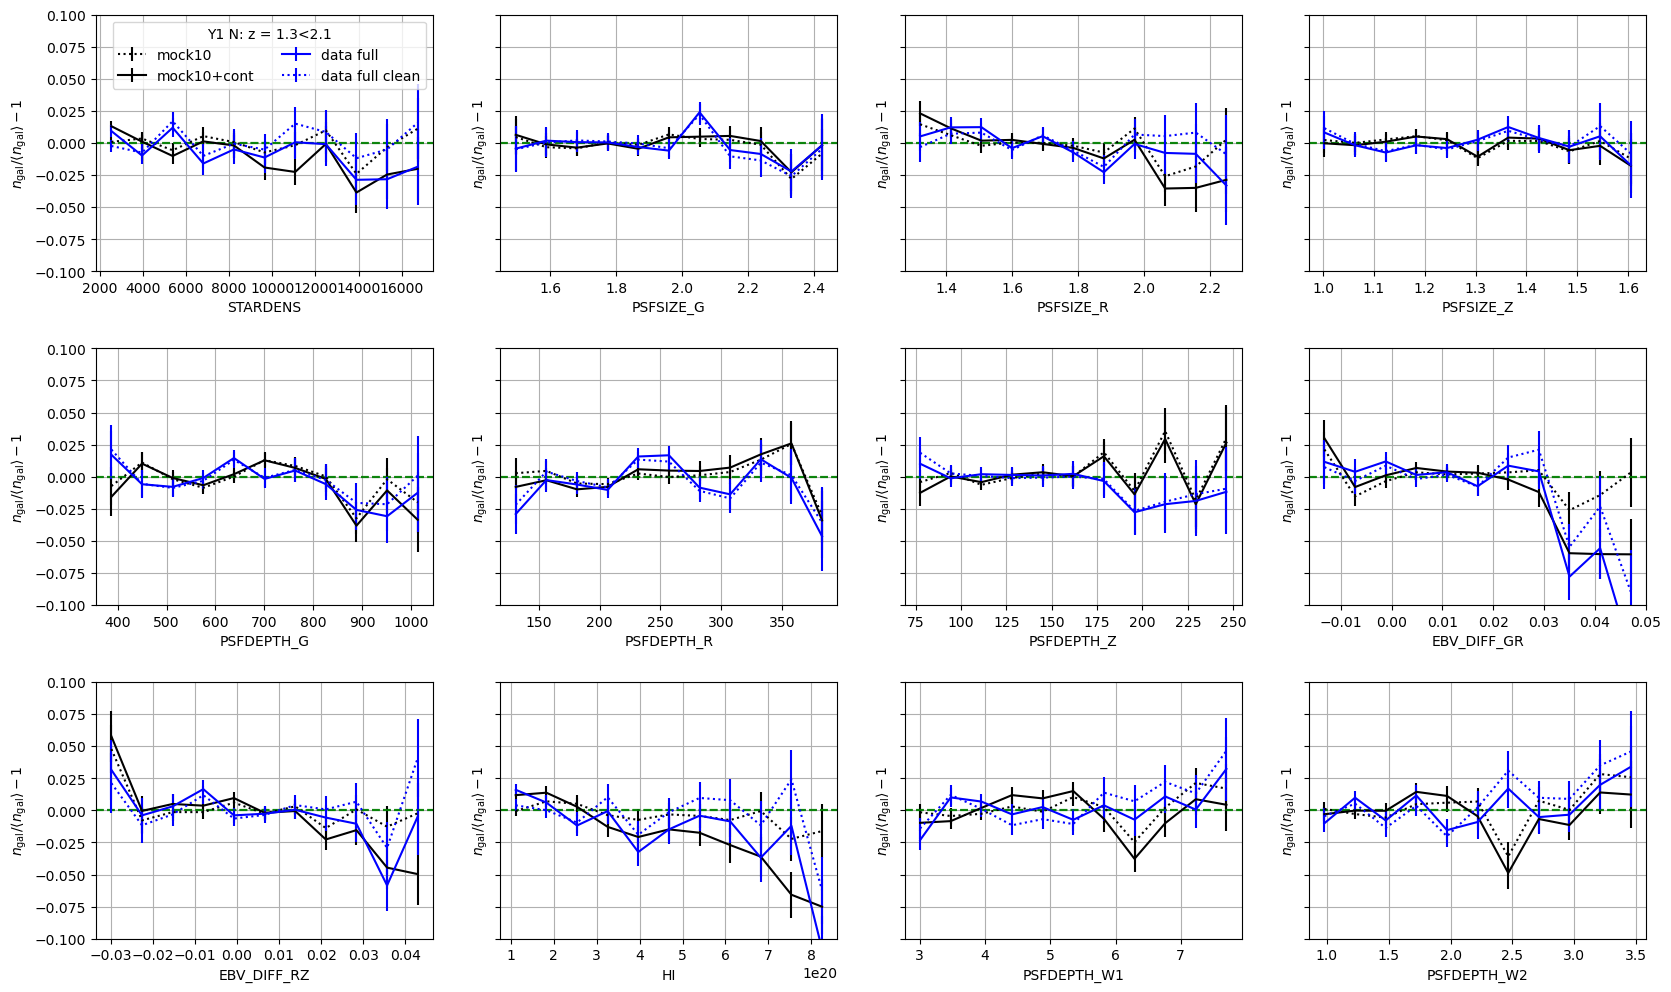

3


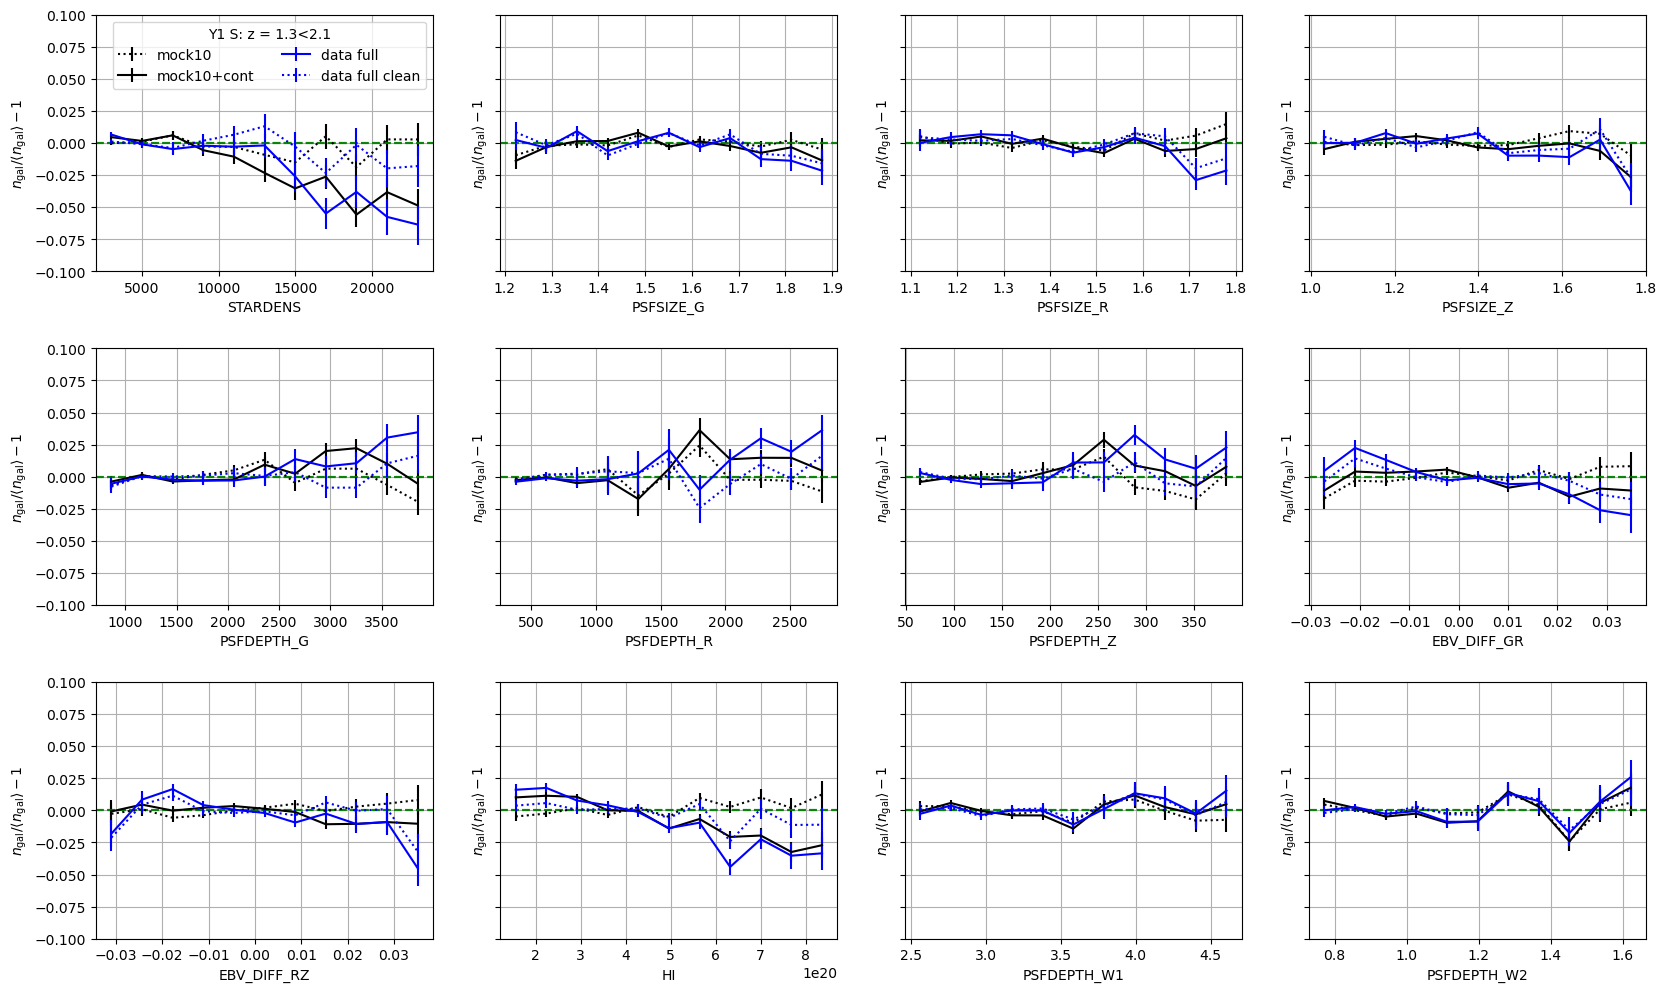

In [12]:
binning = 'linear'
if tp[:3] == 'ELG':
    ylim = (-0.2, +0.2)
if tp[:3] == 'QSO':
    ylim = (-0.1, +0.1)
if tp[:3] == 'LRG':
    ylim = (-0.1, +0.1) 
if tp[:3] == 'BGS':
    ylim = (-0.2, +0.2) 

for iz,zl in enumerate(zrl):
    zw = str(zl[0])+'_'+str(zl[1])
    zmin,zmax = zl[0],zl[1]
    print(zw)
    for ir, reg in enumerate(['N','S']):
        if iz == 0:
            if reg =='N': i = 0
            else: i = 1
        else:
            if reg =='N': i = 2
            else: i = 3 
        print(i)
        #plot
        fig,lax = plt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figsize=(20,12))
        fig.subplots_adjust(hspace=0.3,wspace=0.2)
        lax = lax.flatten()
        add_maps = []
        for iax, prop in enumerate(fit_maps+add_maps):
            kws = dict(binning=binning,ylim=ylim)
            #mock
            ut.plot_density_variations(lax[iax], dat_maps[i], rands_maps[i], hpmapsl[i], prop, maskl[i], label=f'mock{mockid}', color='k', linestyle=':', **kws)
            ut.plot_density_variations(lax[iax], cont_maps[i], rands_maps[i], hpmapsl[i], prop, maskl[i], label=f'mock{mockid}+cont', color='k', linestyle='-', **kws)

            # data
            ut.plot_density_variations(lax[iax], dat_full_list[i], rands_full_list[i], hpmapsl[i], prop, maskl[i], label=f'data full', color='b', linestyle='-', **kws)
            ut.plot_density_variations(lax[iax], dat_fullc_list[i], rands_full_list[i], hpmapsl[i], prop, maskl[i], label=f'data full clean', color='b', linestyle=':', **kws)

            lax[iax].axhline(y=1.0, color='g')
        lax[0].legend(title=f'Y1 {reg}: z = {zmin}<{zmax}', ncol=2)
        plt.savefig(prep_mockdir+f"/density_{tp}_{reg}_{zmin}_{zmax}.pdf")
        plt.show()

# Conaminate Mock (previous method)

In [7]:
%%time
# load data
datl = []
datn = []
dats = []
for reg in ['NGC','SGC']:
    if tp=='ELG_LOPnotqso':
        tp_="ELG_LOP"
        dfn = os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_clustering.dat.fits")
    else:
        dfn = os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_clustering.dat.fits")  
    print(dfn)
    dat = fitsio.read(dfn)
    #zgood = (dat['Z'] > zmin) & (dat['Z'] < zmax)
    #dat = dat[zgood]
    if reg == 'NGC':
        is_north = dat['DEC'] >= 32.375
        datn.append(dat[is_north])
        dats.append(dat[~is_north])
    else:
        dats.append(dat)
    datl.append(dat)
dat = np.concatenate(datl)
datn = np.concatenate(datn)
dats = np.concatenate(dats)

# load randoms
ranl = []
rands_n = []
rands_s = []
for reg in ['NGC','SGC']:
    if tp=='ELG_LOPnotqso':
        tp_="ELG_LOP"
        rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
    else:
        rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
    #print(rfn_l)
    for rfn in rfn_l:
        ran = fitsio.read(rfn, columns=['RA', 'DEC']) 
        if reg == 'NGC':
            is_north = ran['DEC'] >= 32.375
            rands_n.append(ran[is_north])
            rands_s.append(ran[~is_north])
        else:
            rands_s.append(ran)
        ranl.append(ran)
drands = np.concatenate(ranl)
rands_n = np.concatenate(rands_n)
rands_s = np.concatenate(rands_s)

/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock10/ELG_LOP_complete_gtlimaging_NGC_clustering.dat.fits
/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock10/ELG_LOP_complete_gtlimaging_SGC_clustering.dat.fits
CPU times: user 11.8 s, sys: 8.71 s, total: 20.5 s
Wall time: 22 s


In [8]:
if tp[:3] == 'ELG':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','EBV_DIFF_GR','EBV_DIFF_RZ','HI']

if tp[:3] == 'BGS':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','HI']

if tp[:3] == 'LRG':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','HI','PSFDEPTH_W1']
    #fit_maps.append('PSFDEPTH_W1')
#    fit_maps = ['STARDENS','HI','BETA_ML','GALDEPTH_G', 'GALDEPTH_R','GALDEPTH_Z','PSFDEPTH_W1','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z']

if tp[:3] == 'QSO':
    fit_maps = ['STARDENS','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z','EBV_DIFF_GR','EBV_DIFF_RZ','HI']
    fit_maps.append('PSFDEPTH_W1')
    fit_maps.append('PSFDEPTH_W2')
    
print(len(fit_maps),fit_maps)

10 ['STARDENS', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'EBV_DIFF_GR', 'EBV_DIFF_RZ', 'HI']


In [9]:
dat['Z'].min(),dat['Z'].max()

(0.80000013, 1.5999999)

	 0.8 1.1
unseen values:  0
14.039653011325 14.256834983825684
unseen values:  2
148736
[False False False ... False False False] [327767 463275]
Spline extrapolation finished at 0.011 s
[-1.6375e+30 -1.6375e+30] 2
[16.87812166 15.31956673] 2


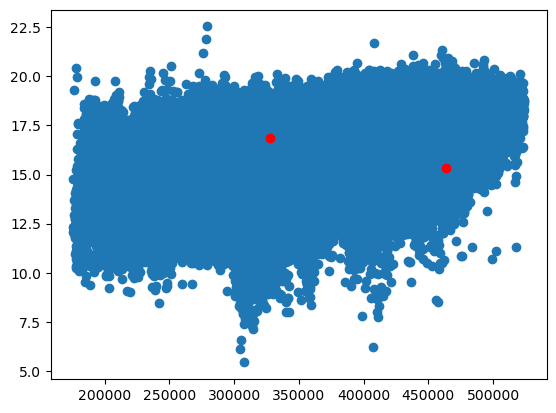

16.0830725574402 16.25387191772461
	 1.1 1.6
unseen values:  0
17.265921102375117 17.469200134277344
unseen values:  4
149010
[False False False ... False False False] [286538 324683 471539 476595]
Spline extrapolation finished at 0.010 s
[-1.6375e+30 -1.6375e+30 -1.6375e+30 -1.6375e+30] 4
[22.03443955 23.92443314 23.72861354 23.1688776 ] 4


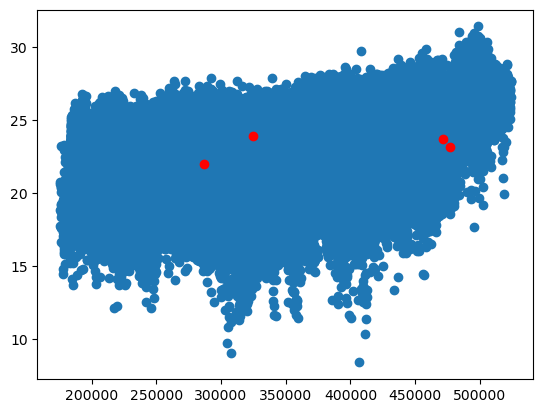

22.870142270368866 23.05999183654785
CPU times: user 25.7 s, sys: 6.18 s, total: 31.9 s
Wall time: 31.9 s


In [10]:
%%time
# maps used when fitting for weights
"""
bands = ["G","R","Z"]
if tp[:3] == 'ELG':
    fit_maps = ['STARDENS'] + \
               [f'PSFSIZE_{b}' for b in bands] + \
               [f'GALDEPTH_{b}' for b in bands] + \
               ['EBV_DIFF_GR','EBV_DIFF_RZ','HI']
print(len(fit_maps),fit_maps)
"""

# load Ronpu EBV maps
dirmap = '/global/cfs/cdirs/desicollab/users/rongpu/data/ebv/v0/kp3_maps/'
eclrs = ['gr','rz']
debv = Table()
for ec in eclrs:
    ebvn = fitsio.read(dirmap+'v0_desi_ebv_'+ec+'_'+str(nside)+'.fits')
    debv_a = ebvn['EBV_DESI_'+ec.upper()]-ebvn['EBV_SFD']
    debv_a = hp.reorder(debv_a,r2n=True)
    debv['EBV_DIFF_'+ec.upper()] = debv_a
    
dat_maps = []
cont_maps = []
rands_maps = []
hpmapsl = []
maskl = []
for zl in zrl:
    zw = str(zl[0])+'_'+str(zl[1])
    zmin,zmax = zl[0],zl[1]
    print('\t',zmin,zmax)
    for reg in ['N','S']:
        sn_fn = os.path.join(prep_mockdir,f"nn-weights_{tp}{zw}_NS.fits")
        sn = hp.read_map(sn_fn)   
        #hp.mollview(sn,rot=260)
        #plt.show()
        pwf = os.path.join(survey_dir,'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'_'+reg+'.fits')
        sys_tab = Table.read(pwf)
        cols = list(sys_tab.dtype.names)
        for col in cols:
            if 'DEPTH' in col:
                bnd = col.split('_')[-1]
                sys_tab[col] *= 10**(-0.4*common.ext_coeff[bnd]*sys_tab['EBV'])
        for ec in ['GR','RZ']:
            if 'EBV_DIFF_'+ec in fit_maps: 
                sys_tab['EBV_DIFF_'+ec] = debv['EBV_DIFF_'+ec]
        
        if reg == 'N':
            d,r = datn,rands_n
        else:
            d,r = dats, rands_s
        zgood = (d['Z'] > zmin) & (d['Z'] < zmax)
    
        dpixs = sysnet_tools.radec2hpix(nside,d[zgood]['RA'],d[zgood]['DEC'])
        is_unseen = sn[dpixs] == hp.UNSEEN
        print('unseen values: ', is_unseen.sum())
        if is_unseen.sum() != 0:
            # extrapolate any missing weights
            pix = np.unique(dpixs)
            print(pix.size)
            pixi,wts = extrapolate_weights(np.sort(pix), sn, k=1, der=0)
            print(sn[pixi],sn[pixi].size)
            sn[pixi] = wts
            print(sn[pixi],sn[pixi].size)
            plt.scatter(pix,sn[pix])
            plt.scatter(pixi,sn[pixi],c='r')
            plt.show()
        #print(dpixs,sn[dpixs])
        print(np.mean(sn[dpixs]),np.median(sn[dpixs]))
        wts = sn[dpixs]/np.median(sn[dpixs])
        
        data_hpmap, rands_hpmap = sysnet_tools.hpixelize(nside, d[zgood], r)
        cont_hpmap = sysnet_tools.hpixsum(nside,d[zgood]['RA'],d[zgood]['DEC'],weights=wts)
        hpmaps = sysnet_tools.create_sysmaps(sys_tab, nest=nest, columns=fit_maps)
        dat_maps.append(data_hpmap)
        cont_maps.append(cont_hpmap)
        rands_maps.append(rands_hpmap)
        hpmapsl.append(hpmaps)
        maskl.append(rands_hpmap>0)
        


In [11]:
%%time 
# load full data catalog
zcolumn = 'Z_not4clus'
keep = ["RA","DEC","TARGETID","PHOTSYS","FRACZ_TILELOCID","WEIGHT_ZFAIL",
        "ZWARN","o2c","FRAC_TLOBS_TILES",zcolumn]#"WEIGHT_SYS"]
dfn = os.path.join(survey_dir,f"{tp}_full.dat.fits")
print(dfn)
dat_full = fitsio.read(dfn)#,columns=keep)

# load full randoms
rfn_l = [os.path.join(survey_dir,f"{tp}_{i}_full.ran.fits") for i in range(0,nran)]
#print(rfn_l)
ranl = []
for rfn in rfn_l:
    ran = fitsio.read(rfn, columns=['RA', 'DEC','PHOTSYS']) 
    ranl.append(ran)
rands = np.concatenate(ranl)

#selection
#sel_obs = dat_full['ZWARN'] != 999999
#sel_obs &= dat_full['o2c'] > 0.9
#sel_obs &= (zmin < dat_full[zcolumn]) & (dat_full[zcolumn] < zmax)

dat_full_list   = []
dat_fullc_list  = []
rands_full_list = []
mask_full_list = []
for zl in zrl:
    zw = str(zl[0])+'_'+str(zl[1])
    zmin,zmax = zl[0],zl[1]
    print(zw)
    for reg in ['N','S']:
        sn_fn = os.path.join(survey_dir,"sysnet",f"{tp}{zw}_{reg}","nn-weights.fits")
        sn_weights = fitsio.read(sn_fn)
        pred_counts = np.mean(sn_weights['weight'],axis=1)
        pix_weight = np.mean(pred_counts)/pred_counts
        pix_weight = np.clip(pix_weight,0.5,2.)
        sn_pix = sn_weights['hpix']
        snmap = np.ones(12*256*256)
        for pix,wt in zip(sn_pix,pix_weight):
            snmap[pix] = wt
        seld = dat_full['PHOTSYS'] ==  reg
        selr = rands['PHOTSYS'] == reg
        d = dat_full[seld]
        d = sysnet_tools.do_zcut(d,zmin,zmax,zcolumn,tp=tp[:3])
        r = rands[selr]
        dpix = sysnet_tools.radec2hpix(nside,d['RA'],d['DEC'])

        dwts = 1./d['FRAC_TLOBS_TILES'] * 1./d['FRACZ_TILELOCID'] * d['WEIGHT_ZFAIL']
        dat_full_list.append(sysnet_tools.hpixsum(nside, d['RA'],d['DEC'],weights=dwts))
        rmap = sysnet_tools.hpixsum(nside, r['RA'],r['DEC'])
        rands_full_list.append(rmap)
        mask_full_list.append(rmap>0)
        dat_fullc_list.append(sysnet_tools.hpixsum(nside, d['RA'],d['DEC'],weights=dwts*snmap[dpix]))


/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/ELG_LOPnotqso_full.dat.fits
0.8_1.1
# removed from quality and zcut 0.8<1.1: 1915964, 92.07%
# removed from quality and zcut 0.8<1.1: 8429236, 90.59%
1.1_1.6
# removed from quality and zcut 1.1<1.6: 1875971, 90.15%
# removed from quality and zcut 1.1<1.6: 8060607, 86.62%
CPU times: user 1min 24s, sys: 52.5 s, total: 2min 17s
Wall time: 2min 18s


0.8_1.1
0


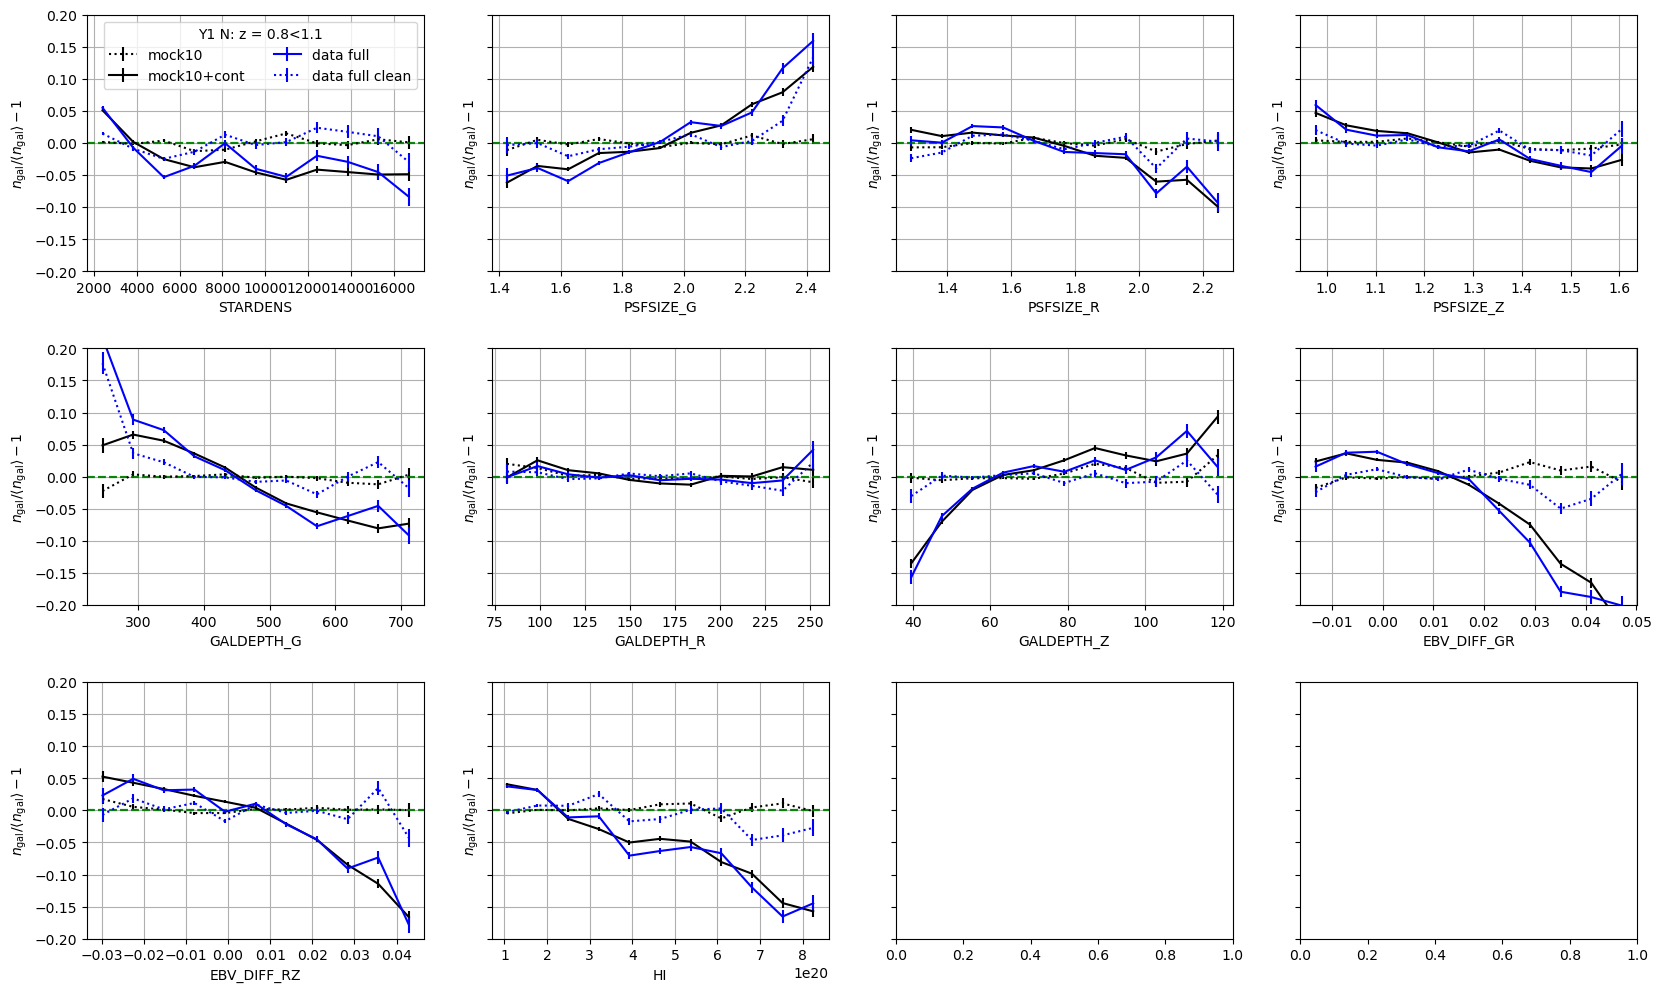

1


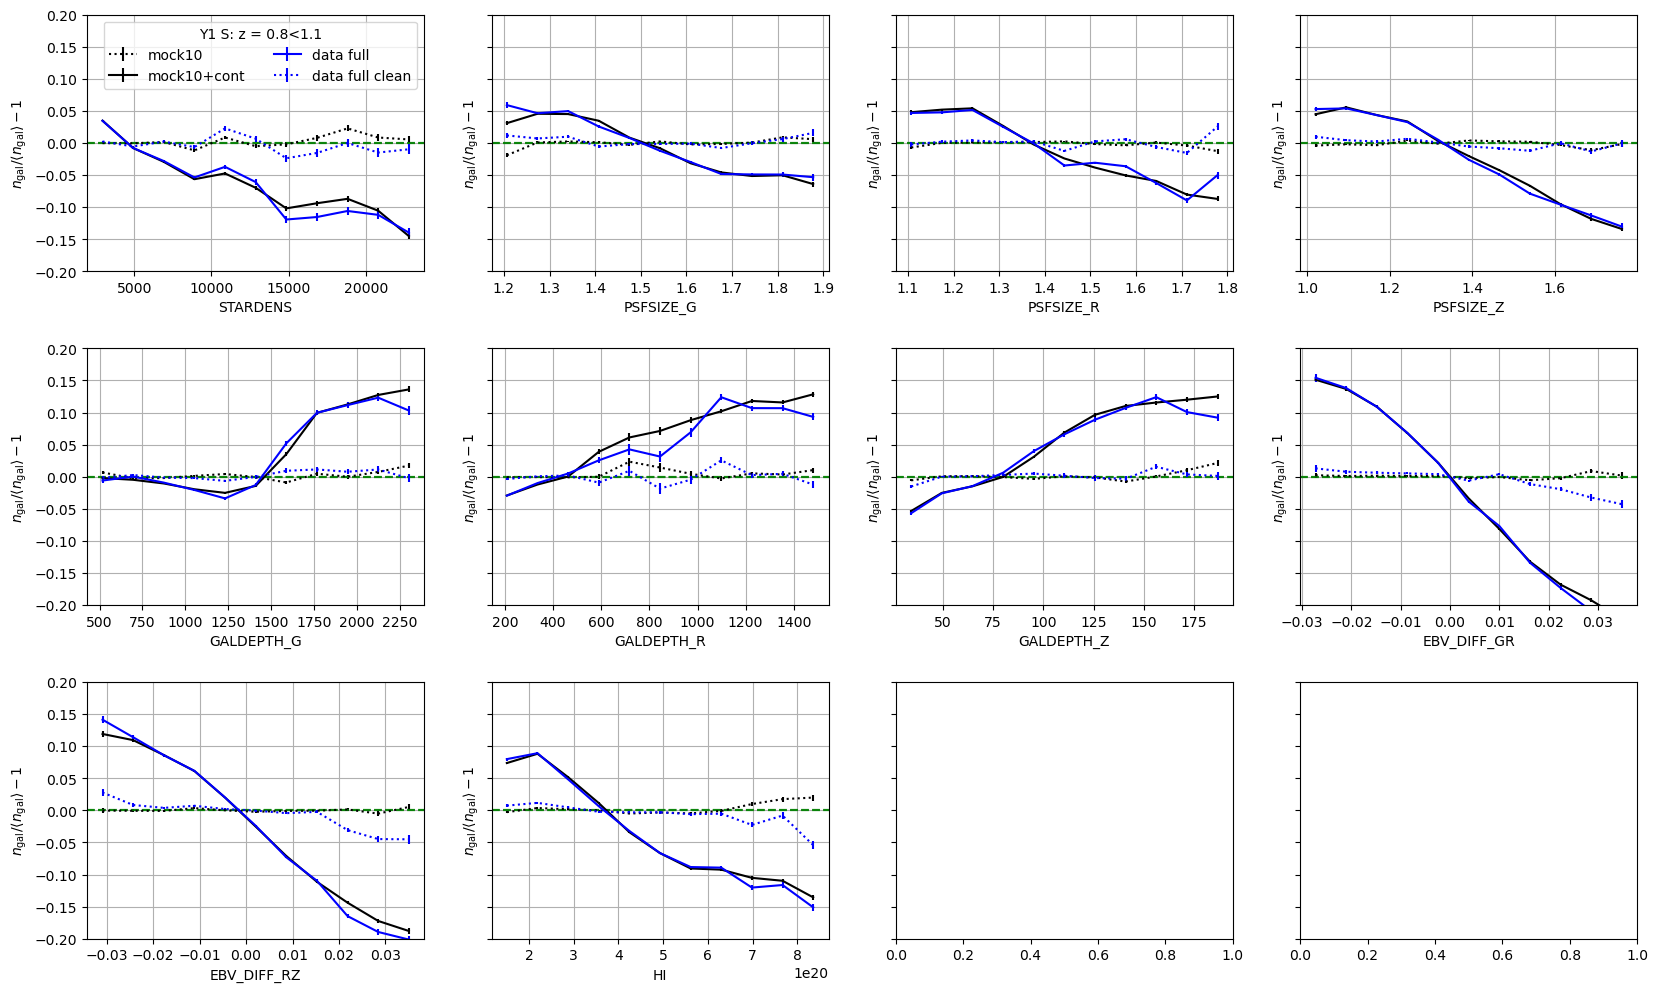

1.1_1.6
2


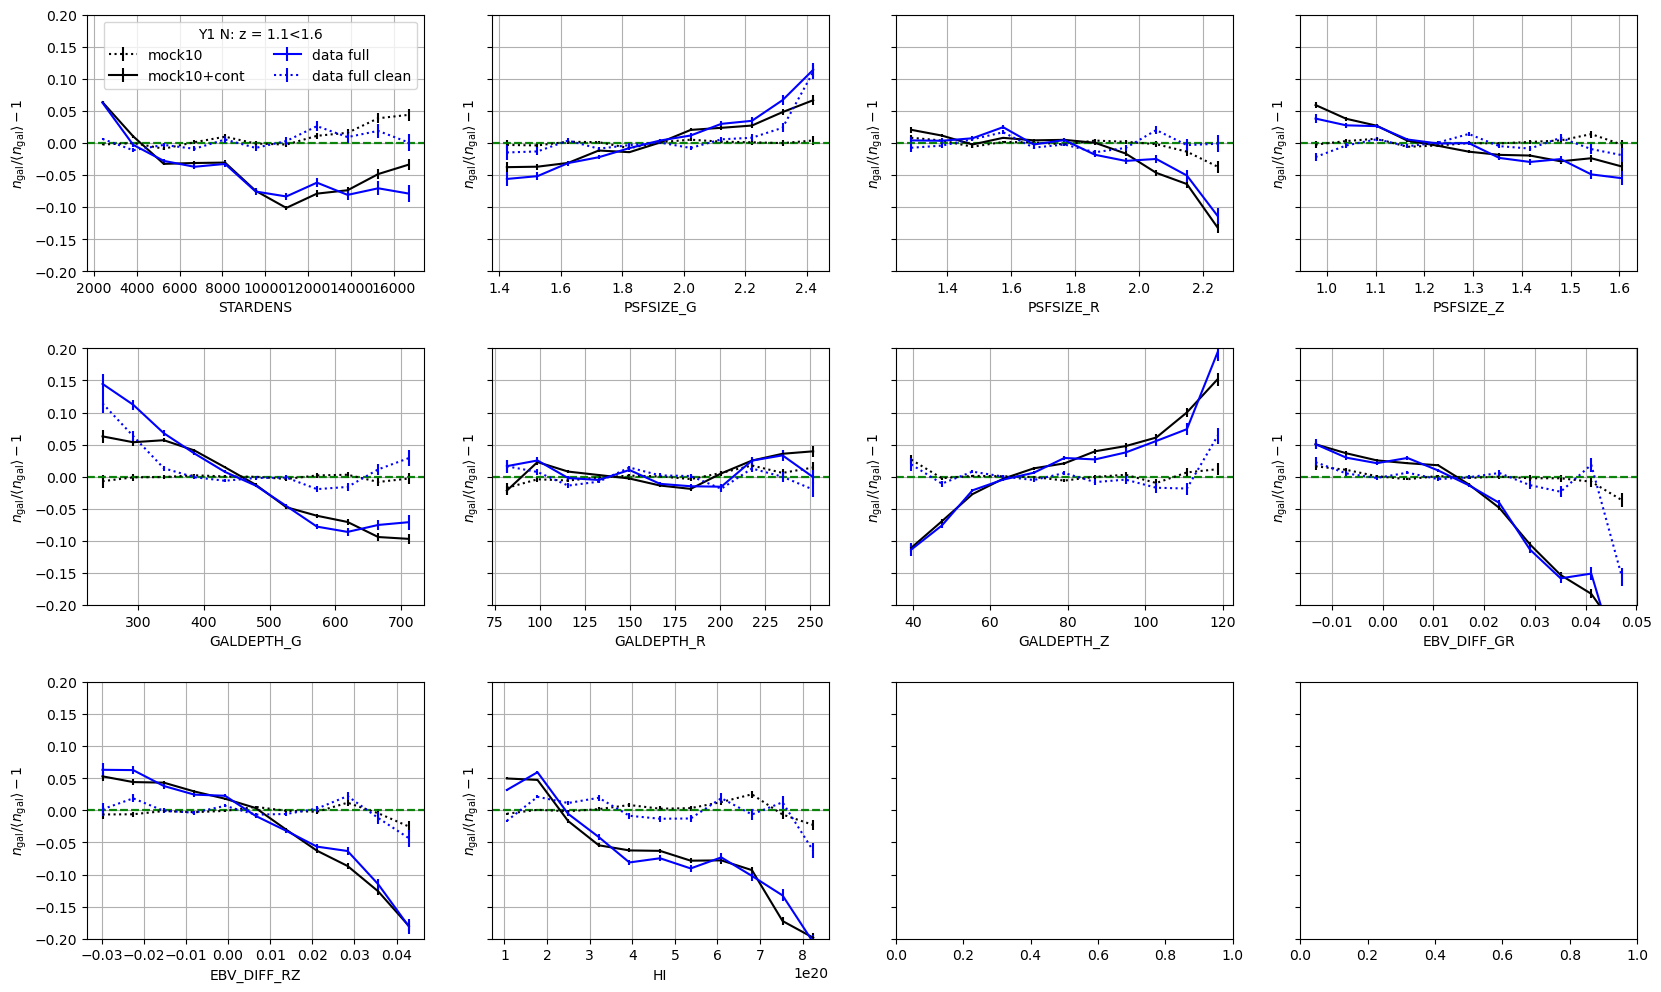

3


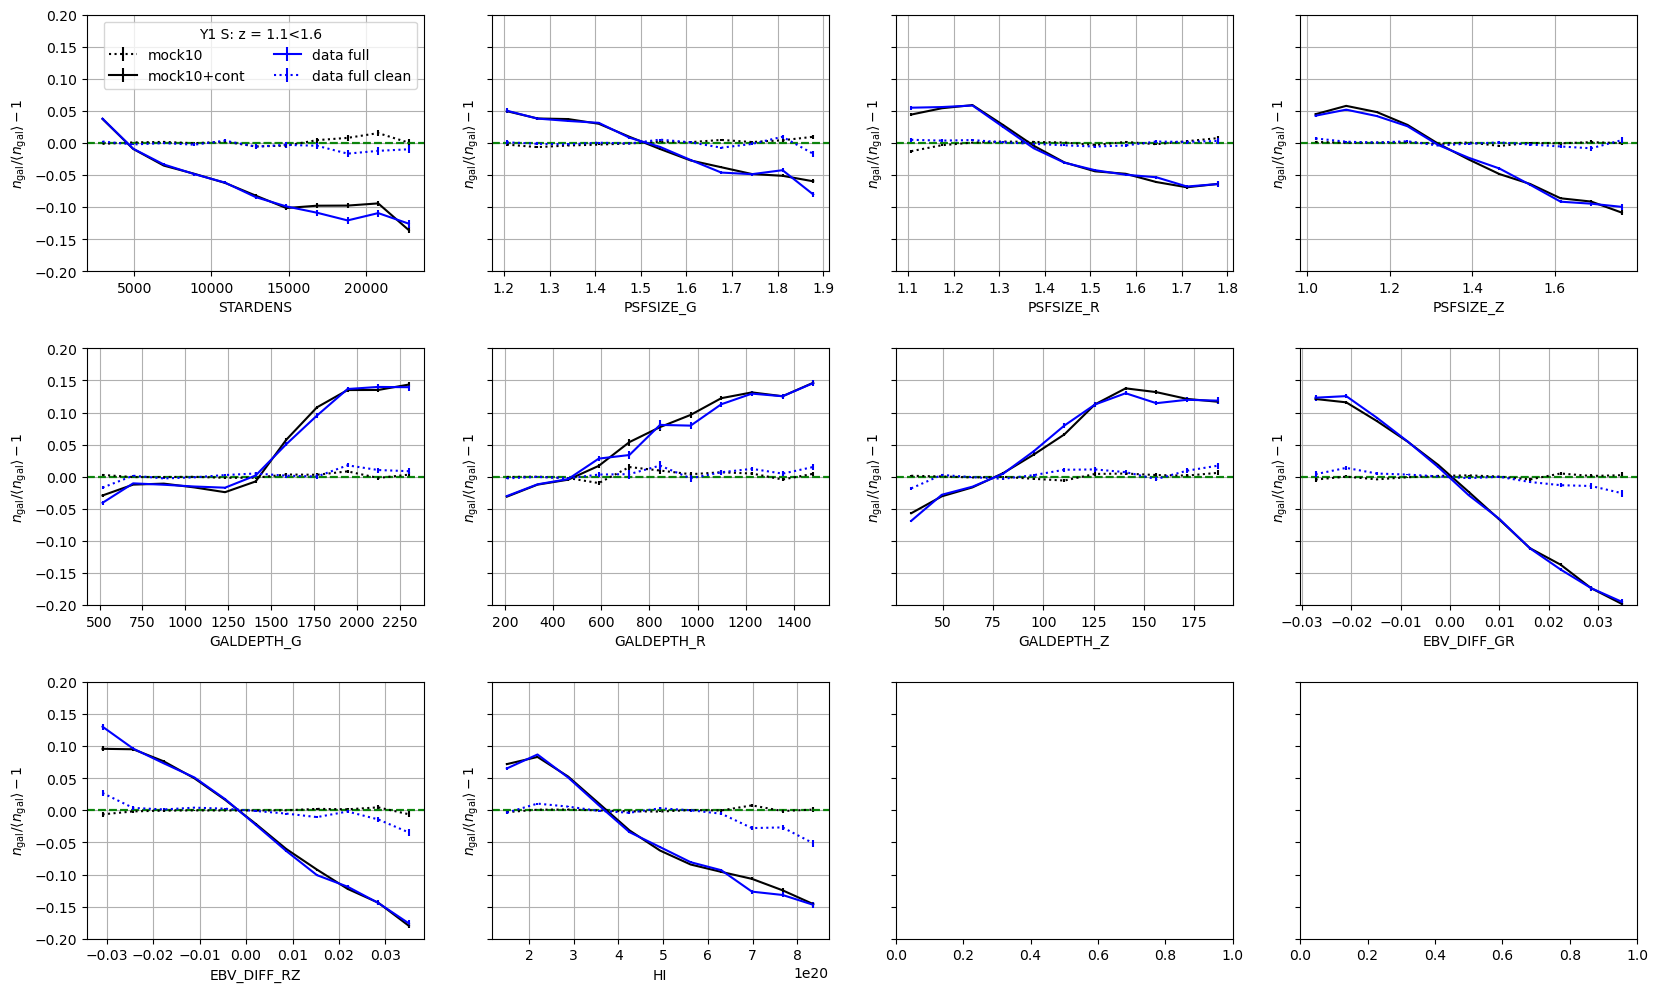

In [12]:
binning = 'linear'
if tp[:3] == 'ELG':
    ylim = (-0.2, +0.2)
if tp[:3] == 'QSO':
    ylim = (-0.1, +0.1)
if tp[:3] == 'LRG':
    ylim = (-0.1, +0.1) 
if tp[:3] == 'BGS':
    ylim = (-0.2, +0.2) 

for iz,zl in enumerate(zrl):
    zw = str(zl[0])+'_'+str(zl[1])
    zmin,zmax = zl[0],zl[1]
    print(zw)
    for ir, reg in enumerate(['N','S']):
        if iz == 0:
            if reg =='N': i = 0
            else: i = 1
        else:
            if reg =='N': i = 2
            else: i = 3 
        print(i)
        #plot
        fig,lax = plt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figsize=(20,12))
        fig.subplots_adjust(hspace=0.3,wspace=0.2)
        lax = lax.flatten()
        add_maps = []
        for iax, prop in enumerate(fit_maps+add_maps):
            kws = dict(binning=binning,ylim=ylim)
            #mock
            ut.plot_density_variations(lax[iax], dat_maps[i], rands_maps[i], hpmapsl[i], prop, maskl[i], label=f'mock{mockid}', color='k', linestyle=':', **kws)
            ut.plot_density_variations(lax[iax], cont_maps[i], rands_maps[i], hpmapsl[i], prop, maskl[i], label=f'mock{mockid}+cont', color='k', linestyle='-', **kws)

            # data
            ut.plot_density_variations(lax[iax], dat_full_list[i], rands_full_list[i], hpmapsl[i], prop, maskl[i], label=f'data full', color='b', linestyle='-', **kws)
            ut.plot_density_variations(lax[iax], dat_fullc_list[i], rands_full_list[i], hpmapsl[i], prop, maskl[i], label=f'data full clean', color='b', linestyle=':', **kws)

            lax[iax].axhline(y=1.0, color='g')
        lax[0].legend(title=f'Y1 {reg}: z = {zmin}<{zmax}', ncol=2)
        plt.savefig(prep_mockdir+f"/density_{tp}_{reg}_{zmin}_{zmax}.pdf")
        plt.show()

1.1_1.6


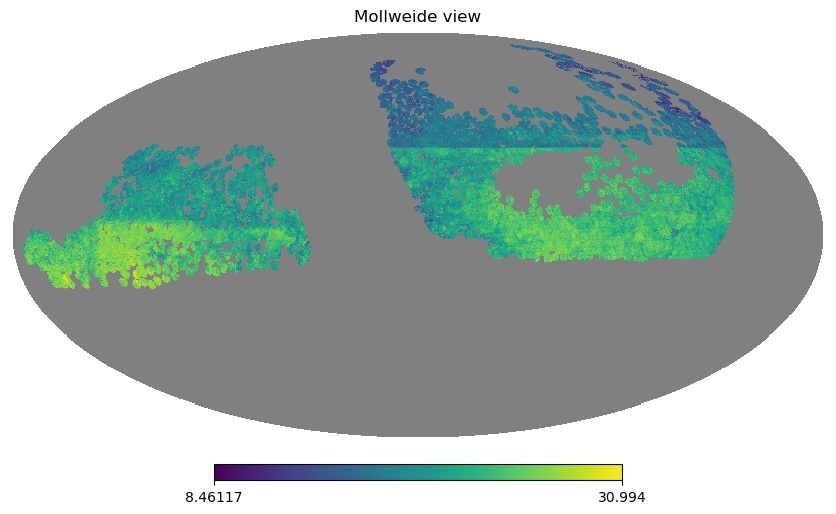

In [6]:
zl = zrl[1]
zw = str(zl[0])+'_'+str(zl[1])
print(zw)
fn = os.path.join(prep_mockdir,f"nn-weights_{tp}{zw}_NS.fits")
pixm = hp.read_map(fn)
#fn = '/global/homes/a/arosado/sysgen2/nn-weights_ELG_LOPnotqso1.1_1.6_NS.fits'
#pixm2 = hp.read_map(fn)
hp.mollview(pixm,rot=260)

In [7]:
d = dats
r = rands_s
zmin,zmax = zrl[1]
print(zmin,zmax)
#zgood = (d['Z'] > zmin) & (d['Z'] < zmax)
#dpixs = sysnet_tools.radec2hpix(nside,d['RA'][zgood],d['DEC'][zgood])
dpixs = sysnet_tools.radec2hpix(nside,d['RA'],d['DEC'])
pixs = np.unique(dpixs)
sn_weights = pixm[pixs]
is_unseen = sn_weights == hp.UNSEEN
is_unseen.sum(),pixs.size

1.1 1.6


(5683, 149527)

In [8]:
t = fitsio.read(prep_mockdir+f"/prep_{tp}1.1_1.6_S.fits")
sn_weights = pixm[t['hpix']]
is_unseen = sn_weights == hp.UNSEEN
is_unseen.sum(),pixs.size- t['hpix'].size

(6034, -1041)

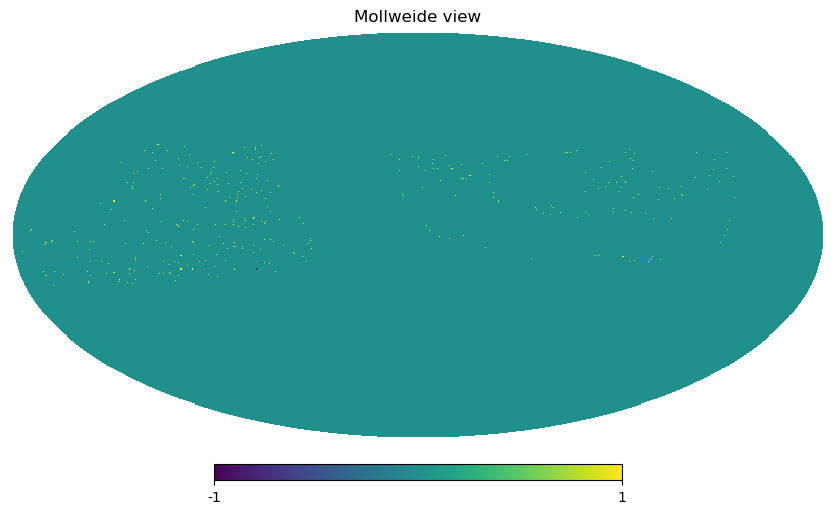

In [9]:
m1 = np.zeros(12*nside*nside)
m1[pixs] = 1
m2 = np.zeros(12*nside*nside)
m2[t['hpix']] = 1
hp.mollview(m2-m1,rot=260)